## Validate the data (tables) stored in Amazon S3.

In [147]:
import configparser
import os
from datetime import datetime

#import logging
#import boto3
#from botocore.exceptions import ClientError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkContext

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format

from pyspark.sql.types import StringType, IntegerType, TimestampType, DateType

from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as f

from pyspark.sql import SQLContext

## Read from the AWS credentials from config file

In [148]:
config = configparser.ConfigParser()
config.read('dl.cfg')

['dl.cfg']

In [149]:
os.environ['AWS_ACCESS_KEY_ID']= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']= config['AWS']['AWS_SECRET_ACCESS_KEY']

KEY= config['AWS']['AWS_ACCESS_KEY_ID']
SECRET= config['AWS']['AWS_SECRET_ACCESS_KEY']

In [150]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

In [151]:
spark = create_spark_session()

In [152]:
spark

## Read the data from S3 bucket

In [153]:
output = "s3a://desh1gvrk/parquet"
input =  "s3a://udacity-dend/"

### Read the Songplays fact dimension table

In [154]:
songplays = output + '/songplays'
songplays_df = spark.read.parquet(songplays)
tot_fact_records = songplays_df.count()

In [155]:
print("Number of records in Fact Table: {}".format(tot_fact_records))

Number of records in Fact Table: 6820


### Filter all the records which have Non NULL song_id

In [156]:
fact_songNN = songplays_df.filter(songplays_df.song_id.isNotNull())

### Create View of the Fact Table

In [157]:
fact_songNN.createOrReplaceTempView('fact_songNN')

### Create View of the users dimension (Output) table

In [158]:
users = spark.read.parquet(output + '/users')

In [160]:
users.createOrReplaceTempView('users')

In [161]:
users.show()

+------+----------+---------+------+-----+
|userId| firstName| lastName|gender|level|
+------+----------+---------+------+-----+
|    88|  Mohammad|Rodriguez|     M| paid|
|    88|  Mohammad|Rodriguez|     M| free|
|    68|    Jordan|Rodriguez|     F| free|
|    29|Jacqueline|    Lynch|     F| free|
|    11| Christian|   Porter|     F| free|
|    53|   Celeste| Williams|     F| free|
|    69|  Anabelle|  Simpson|     F| free|
|    75|    Joseph|Gutierrez|     M| free|
|    40|    Tucker| Garrison|     M| free|
|     2|   Jizelle| Benjamin|     F| free|
|    14|  Theodore|   Harris|     M| free|
|    52|  Theodore|    Smith|     M| free|
|    56|    Cienna|  Freeman|     F| free|
|    12|    Austin|  Rosales|     M| free|
|    19|   Zachary|   Thomas|     M| free|
|    23|    Morris|  Gilmore|     M| free|
|    55|    Martin|  Johnson|     M| free|
|    66|     Kevin| Arellano|     M| free|
|    64|    Hannah|  Calhoun|     F| free|
|   100|     Adler|  Barrera|     M| free|
+------+---

### Create View of the artists dimension (Output) table

In [172]:
artists = spark.read.parquet(output + '/artists')

In [173]:
artists.createOrReplaceTempView('artists')

In [174]:
artists.limit(5).show()

+------------------+--------------------+--------------------+---------------+----------------+
|         artist_id|         artist_name|     artist_location|artist_latitude|artist_longitude|
+------------------+--------------------+--------------------+---------------+----------------+
|ARXG6L11187FB5695E|SWAMI featuring A...|Birmingham/ Londo...|       52.47859|         -1.9086|
|ARWAFY51187FB5C4EF|         Lil Scrappy|         Atlanta, GA|           null|            null|
|AR2IQVG1187B98DEAB|           Kid Koala|Vancouver, Britis...|       49.26044|      -123.11403|
|ARVW94P1187B9B56AF|Queen + Paul Rodgers|                    |           null|            null|
|ARL26PR1187FB576E5|      Camera Obscura|   Glasgow, Scotland|           null|            null|
+------------------+--------------------+--------------------+---------------+----------------+



### Function to plot a bar graph

In [181]:
def plot(y_pos, performance, objects, l, b, clr, xlb, title, out):
    fig= plt.figure(figsize=(l, b))
    plt.barh(y_pos, performance, align='center', alpha=0.7, color = clr)
    plt.yticks(y_pos, objects)

    plt.xlabel(xlb)
    plt.title(title)
    
    plt.savefig(out)
    plt.show()

In [163]:
%matplotlib inline

In [164]:
plt.rcParams.update({'font.size': 22})

## Find which artist's songs were the most heard in 11/2018

In [196]:
df = spark.sql("SELECT artist_name, COUNT \
                FROM ( \
                SELECT artist_id, count(1) as COUNT \
                FROM fact_songNN f \
                GROUP BY artist_id ) A \
                LEFT JOIN artists ar \
                ON A.artist_id = ar.artist_id \
                ")

In [197]:
#df = spark.sql("select count(distinct artist_id) from fact_songNN")

In [198]:
result_df = df.select("*").toPandas()

In [195]:
result_df

,count(DISTINCT artist_id)
0,11


In [186]:
objects_p3 = result_df['artist_name'].tolist()
y_pos_p3 = np.arange(len(objects_p3))
performance_p3 = (result_df['COUNT']).tolist()
clr_p3 = ['green' if p == max(performance_p3) else 'grey' for p in performance_p3]

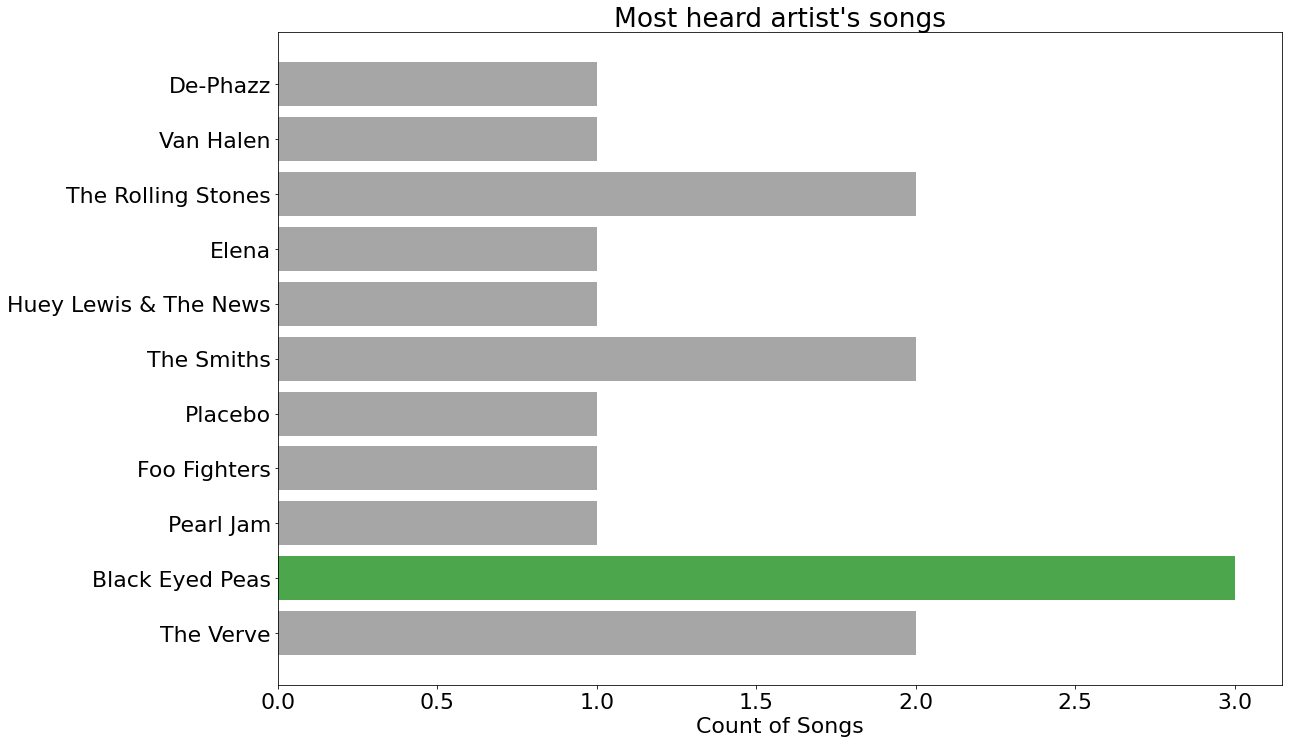

In [187]:
# Bar Graph
plot(y_pos_p3, performance_p3, objects_p3, 18, 12, clr_p3, "Count of Songs", "Most heard artist's songs", "p3")

### Create View of the songs dimension (Output) table

In [200]:
songs = spark.read.parquet(output + '/songs')

In [201]:
songs.createOrReplaceTempView('songs')

## Find the most popular song in the year

In [120]:
df = spark.sql("SELECT s.song_id, title, COUNT \
                FROM \
                (SELECT song_id, count(1) as COUNT \
                 FROM fact_songNN f GROUP BY song_id) A \
                LEFT JOIN songs s \
                ON s.song_id = A.song_id")

In [121]:
result_df = df.select("*").toPandas()

In [122]:
result_df

,song_id,title,COUNT
0,SODOLVO12B0B80B2F4,Hell,1
1,SOFVOQL12A6D4F7456,The Boy With The Thorn In His Side,2
2,SOXQYSC12A6310E908,Bitter Sweet Symphony,2
3,SODWXQV12A6310F10D,English Summer Rain,1
4,SOZCTXZ12AB0182364,Setanta matins,1
5,SOCHRXB12A8AE48069,Let's Get It Started,3
6,SONQBUB12A6D4F8ED0,Angie (1993 Digital Remaster),2
7,SOAOJYY12A58A7B2F9,Not For You,1
8,SOLRYQR12A670215BF,Panama (Remastered Album Version),1
9,SOVWWJW12A670206BE,Astrud Astronette,1


In [137]:
objects_p1 = result_df['title'].tolist()
y_pos_p1 = np.arange(len(objects_p1))
performance_p1 = (result_df['COUNT']).tolist()
clr_p1 = ['green' if p == max(performance_p1) else 'grey' for p in performance_p1]

In [199]:
# Bar Graph
#plot(y_pos_p1, performance_p1, objects_p1, 18, 12, clr_p1, "p1")

## Find the number of songs in the different years

In [91]:
df = spark.sql("SELECT year, COUNT(*) as COUNT FROM songs GROUP BY year")

In [92]:
result_df = df.select("*").toPandas()

In [94]:
def colors(p):
    if p == max(performance):
        return 'green'
    elif p == min(performance):
        return "red"
    else:
        return 'grey'

In [110]:
objects_p2 = result_df['year'].tolist()
y_pos_p2 = np.arange(len(objects))
performance_p2 = (result_df['COUNT']).tolist()
clr_p2 = [colors(p) for p in performance]

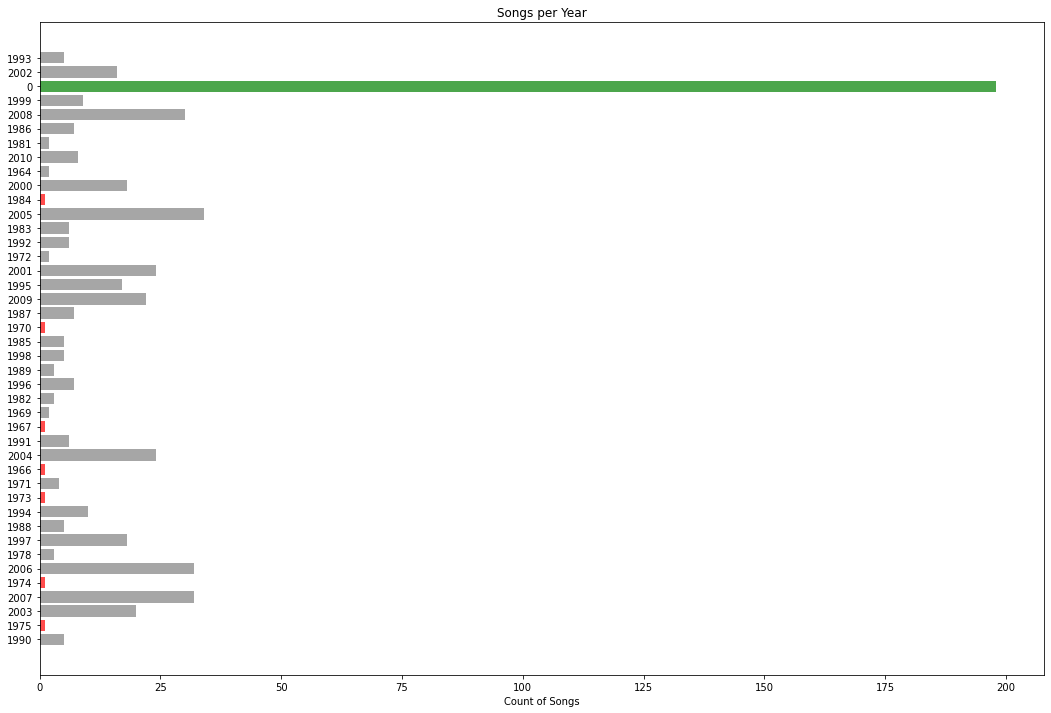

In [119]:
# Bar Graph
plot(y_pos_p2, performance_p2, 18, 12, clr_p2, "p2")

#### Give me the artist, song title and song's length in the music app history that was heard during sessionId = 338, and itemInSession = 4

In [202]:
df = spark.sql("SELECT artist_name, title, duration \
                FROM fact_songNN f \
                LEFT JOIN songs s ON f.song_id = s.song_id \
                LEFT JOIN artists a ON f.artist_id = a.artist_id \
                WHERE session_id = 338")

#### Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182


In [ ]:
df = spark.sql("SELECT artist_name, first_name, last_name, duration \
                FROM fact_songNN f \
                LEFT JOIN users u ON f.user_id = u.user_id \
                LEFT JOIN artists a ON f.artist_id = a.artist_id \
                WHERE session_id = 182 AND user_id = 10 AND user_id ")

#### Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

In [ ]:
df = spark.sql("SELECT first_name, last_name \
                FROM fact_songNN f \
                LEFT JOIN users u ON f.user_id = u.user_id \
                LEFT JOIN songs s ON f.song_id = s.song_id \
                WHERE s.title = 'All Hands Against His Own'")